# AlongTrack Evaluation

> In this notebook, we look at how to evaluate alongtrack data. In the OSSE setting in previous notebooks, we saw that we can evaluate our method on the alongtracks and then compare our learned field with the field from the simulation. In the OSE setting, we don't have the original field. So we need to evaluate the field directly on the leave-one-out alongtrack. We demonstrate some simple statistics in the real and spectral space that we can perform. 

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.geoprocessing.validation import validate_latlon, validate_time, decode_cf_time, validate_ssh
from oceanbench._src.preprocessing.alongtrack import alongtrack_ssh
from oceanbench._src.geoprocessing.subset import where_slice
from oceanbench._src.preprocessing.alongtrack import remove_swath_dimension
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
!ls "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results"

leaderboard.csv			  OSE_ssh_mapping_DUACS.nc
OSE_ssh_mapping_4dvarNet_2022.nc  OSE_ssh_mapping_DYMOST.nc
OSE_ssh_mapping_4dvarNet.nc	  OSE_ssh_mapping_MIOST.nc
OSE_ssh_mapping_BASELINE.nc	  results.csv
OSE_ssh_mapping_BFN.nc


In [3]:

!ls /gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/test

dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc


In [12]:
from oceanbench._src.geoprocessing.validation import validate_latlon, validate_time
from oceanbench._src.preprocessing.alongtrack import alongtrack_ssh
from oceanbench._src.geoprocessing.subset import where_slice



def preprocess_nadir(da):
    
    # reorganized
    da = da.sortby("time").compute()
    
    # validate coordinates
    da = da.rename({"longitude": "lon", "latitude": "lat"})
    da = validate_latlon(da)
    da = validate_time(da)
    
    # slice region
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
    
    # slice time period
    da = da.sel(time=slice("2017-01-01", "2017-12-31"))
    
    # calculate SSH directly
    da = alongtrack_ssh(da)
    
    return da

In [41]:
files_nadir_dc21a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/test/dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc",
]


In [42]:
ds_nadir = xr.open_mfdataset(
    files_nadir_dc21a, 
    preprocess=preprocess_nadir,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
).sortby("time").compute()


ds_nadir

<xarray.Dataset>
Dimensions:         (time: 49859)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01T08:08:42.012641024 ... 2...
    lon             (time) float64 -62.61 -62.61 -62.62 ... -62.09 -62.1 -62.1
    lat             (time) float64 33.03 33.09 33.15 33.2 ... 42.83 42.89 42.95
Data variables:
    cycle           (time) float64 88.0 88.0 88.0 88.0 ... 101.0 101.0 101.0
    track           (time) float64 701.0 701.0 701.0 701.0 ... 353.0 353.0 353.0
    dac             (time) float32 -0.1647 -0.1648 -0.165 ... 0.03 0.0314 0.0327
    lwe             (time) float32 0.003 0.003 0.003 ... -0.029 -0.029 -0.029
    mdt             (time) float32 0.593 0.592 0.591 ... -0.165 -0.164 -0.163
    ocean_tide      (time) float64 -0.3407 -0.3413 -0.342 ... -0.1686 -0.1693
    sla_filtered    (time) float32 -0.136 -0.16 -0.18 -0.194 ... 0.105 0.102 0.1
    sla_unfiltered  (time) float32 -0.151 -0.119 -0.158 ... 0.081 0.097 0.114
    ssh             (time) float32 0.439 0.47 0.43 0.404 ... -0.055 -0.038 -0.02
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

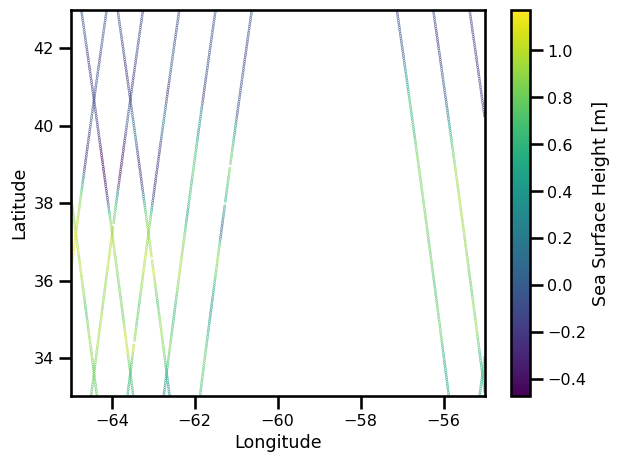

In [43]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.sel(time=slice("2017-01-01", "2017-01-15"))
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds.ssh, s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[ds_nadir.lon.min(), ds_nadir.lon.max()],
    ylim=[ds_nadir.lat.min(), ds_nadir.lat.max()],
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

## Field

Now, we will load a field from a method that interpolated the data. 

In [44]:
# !ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/
!ls /gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results

leaderboard.csv			  OSE_ssh_mapping_DUACS.nc
OSE_ssh_mapping_4dvarNet_2022.nc  OSE_ssh_mapping_DYMOST.nc
OSE_ssh_mapping_4dvarNet.nc	  OSE_ssh_mapping_MIOST.nc
OSE_ssh_mapping_BASELINE.nc	  results.csv
OSE_ssh_mapping_BFN.nc


In [45]:
def preprocess_field(da):
    
    # validate coordinates
    da = validate_latlon(da)
    da = validate_time(da)
    da = validate_ssh(da)
    
    # select region + time period
    da = da.sel(
        time=slice("2017-01-01", "2017-12-31"),
        lon=slice(-65., -55.),
        lat=slice(33., 43.),
    )
    
    return da

## Gridding

In [46]:
file_DUACS = "/gpfswork/rech/yrf/commun/data_challenges/dc21a_ose/test/results/OSE_ssh_mapping_DUACS.nc"

In [47]:
%%time


ds_field = xr.open_mfdataset(
    file_DUACS,
    decode_times=True,
    preprocess=preprocess_field,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_field = ds_field.sortby("time").compute()

ds_field

CPU times: user 23.7 ms, sys: 8.99 ms, total: 32.7 ms
Wall time: 67.8 ms


<xarray.Dataset>
Dimensions:  (lat: 40, lon: 40, time: 365)
Coordinates:
  * lat      (lat) float64 33.12 33.38 33.62 33.88 ... 42.12 42.38 42.62 42.88
  * lon      (lon) float64 -64.88 -64.62 -64.38 -64.12 ... -55.62 -55.38 -55.12
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    ssh      (time, lat, lon) float64 0.817 0.8275 0.8267 ... 0.08649 0.0524
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20170101_20170101_20190823.nc
    CreatedBy:     ballarm@node036.sis.cnes.fr
    CreatedOn:     23-AUG-2019 11:21:19:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2019/08/23 11:21:19 ballarm@node036.sis.cnes.fr Import dep...

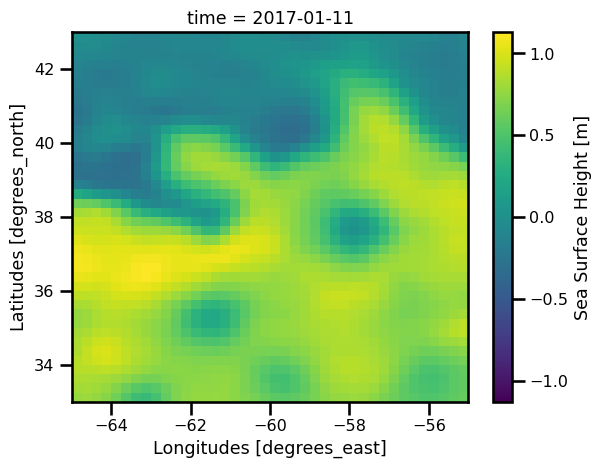

In [48]:
fig, ax = plt.subplots()

ds_field.ssh.isel(time=10).plot.pcolormesh(ax=ax, cmap="viridis")

plt.show()

### Regridding

Now, we will need to regrid our field to the alongtrack data.

In [49]:
from oceanbench._src.geoprocessing.gridding import grid_to_coord_based

In [50]:
ds_field

<xarray.Dataset>
Dimensions:  (lat: 40, lon: 40, time: 365)
Coordinates:
  * lat      (lat) float64 33.12 33.38 33.62 33.88 ... 42.12 42.38 42.62 42.88
  * lon      (lon) float64 -64.88 -64.62 -64.38 -64.12 ... -55.62 -55.38 -55.12
  * time     (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
Data variables:
    ssh      (time, lat, lon) float64 0.817 0.8275 0.8267 ... 0.08649 0.0524
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20170101_20170101_20190823.nc
    CreatedBy:     ballarm@node036.sis.cnes.fr
    CreatedOn:     23-AUG-2019 11:21:19:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2019/08/23 11:21:19 ballarm@node036.sis.cnes.fr Import dep...

In [51]:
ds_nadir["ssh_interp"] = grid_to_coord_based(
    ds_field.transpose("lon", "lat", "time"),
    ds_nadir,
    data_vars=["ssh"], 
)["ssh"]
# np.isfinite(ds_nadir_gridded.ssh.isel(time=6)).plot.imshow()
ds_results = ds_nadir.copy()
# drop all nans
ds_results = ds_results[["ssh", "ssh_interp"]].dropna(dim="time")

In [52]:
ds_results

<xarray.Dataset>
Dimensions:     (time: 47191)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01T08:08:43.899440896 ... 2017-...
    lon         (time) float64 -62.62 -62.63 -62.64 ... -59.19 -59.2 -59.21
    lat         (time) float64 33.15 33.2 33.26 33.32 ... 33.3 33.24 33.18 33.13
Data variables:
    ssh         (time) float32 0.43 0.404 0.364 0.358 ... 0.632 0.612 0.724
    ssh_interp  (time) float64 0.4091 0.4189 0.43 ... 0.7218 0.7214 0.7208
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

We should reduce the area slightly to ensure that the boundaries are not included. It makes the comparison more faire.

In [53]:
ds_results = where_slice(ds_results, "lon", -64.975 + 0.25, -55.007 - 0.25)
ds_results = where_slice(ds_results, "lat", 33.025 + 0.25, 42.9917 - 0.25)
ds_results

<xarray.Dataset>
Dimensions:     (time: 44546)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-01T08:08:46.729640704 ... 2017-...
    lon         (time) float64 -62.64 -62.65 -62.66 ... -59.17 -59.18 -59.19
    lat         (time) float64 33.32 33.38 33.43 33.49 ... 33.41 33.36 33.3
Data variables:
    ssh         (time) float32 0.358 0.382 0.457 0.463 ... 0.66 0.655 0.658
    ssh_interp  (time) float64 0.4415 0.4534 0.4847 ... 0.7216 0.7223 0.7221
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...

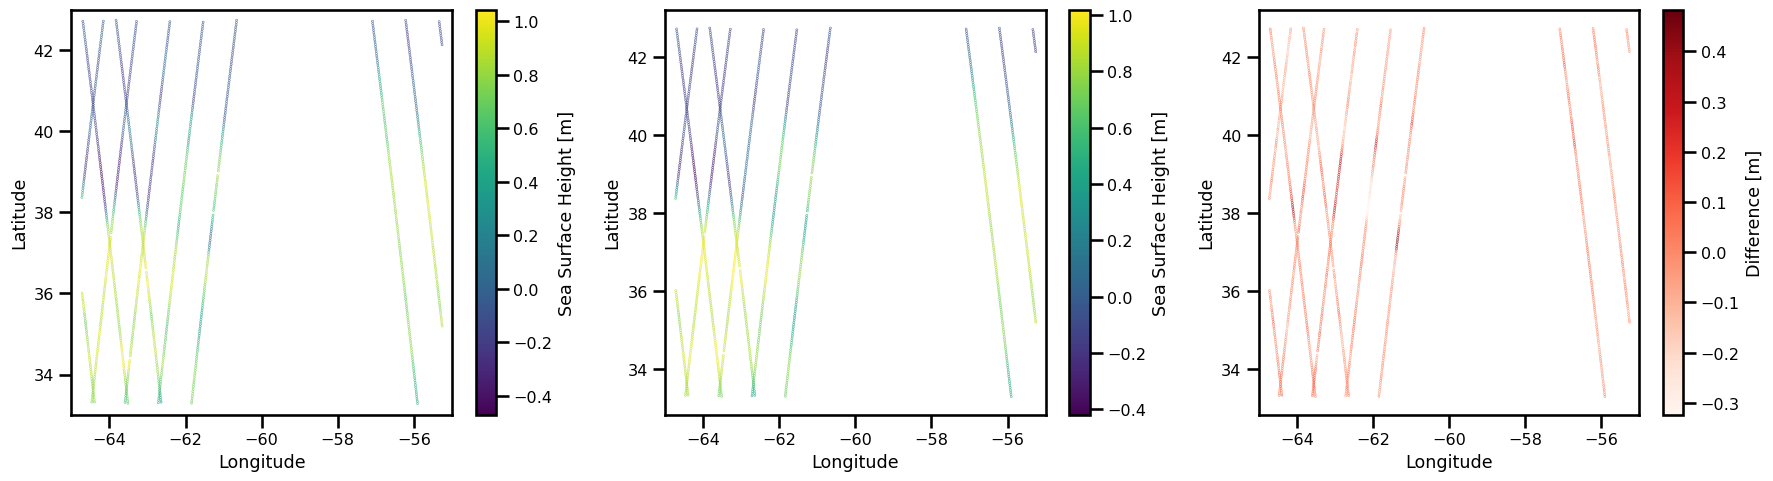

In [54]:
%matplotlib inline

fig, ax = plt.subplots(ncols=3, figsize=(18,5))


# True SSH
sub_ds_ssh = ds_results.ssh.sel(time=slice("2017-01-01","2017-01-15"))
pts = ax[0].scatter(
    sub_ds_ssh.lon, sub_ds_ssh.lat, c=sub_ds_ssh, s=0.1,
    cmap="viridis",
)
ax[0].set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
    ylim=[33., 43.]
)
plt.colorbar(pts, label="Sea Surface Height [m]")

# Predicted SSH
sub_ds_ssh_interp = ds_results.ssh_interp.sel(time=slice("2017-01-01","2017-01-15"))
pts = ax[1].scatter(
    sub_ds_ssh_interp.lon, sub_ds_ssh_interp.lat, c=sub_ds_ssh_interp, s=0.1,
    cmap="viridis",
)
ax[1].set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
)
plt.colorbar(pts, label="Sea Surface Height [m]")


# Predicted SSH
diff = sub_ds_ssh_interp - sub_ds_ssh
pts = ax[2].scatter(diff.lon, diff.lat, c=diff, s=0.1, cmap="Reds")
ax[2].set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
)
plt.colorbar(pts, label="Difference [m]")

plt.tight_layout()
plt.show()

## AlongTrack Segments

**TODO**: Need to explain this better.

In [55]:
velocity = 6.77 # [km/s]
delta_t = 0.9434 # [s]
delta_x = velocity * delta_t # [km]
length_scale = 1000 # [km]

In [56]:
import oceanbench._src.preprocessing.alongtrack as atrack_process
import oceanbench._src.metrics.power_spectrum as psd_calc

In [57]:
ds_segments = atrack_process.select_track_segments(
    ds_results,
    "ssh", "ssh_interp",
    velocity=6.77,
    delta_t=0.9434,
    length_scale=1000,
    segment_overlapping=0.25
)
ds_segments

<xarray.Dataset>
Dimensions:     (segment: 214, track_val: 156)
Coordinates:
  * segment     (segment) int64 0 1 2 3 4 5 6 7 ... 207 208 209 210 211 212 213
    lat         (segment) float64 -63.19 -61.24 -64.05 ... -56.85 -57.69 -60.55
    lon         (segment) float64 37.8 38.31 37.66 38.31 ... 38.16 38.29 37.71
  * track_val   (track_val) int64 0 1 2 3 4 5 6 ... 149 150 151 152 153 154 155
Data variables:
    ssh_interp  (segment, track_val) float64 0.4415 0.4534 ... 0.01457 0.01301
    ssh         (segment, track_val) float32 0.358 0.382 0.457 ... -0.007 0.018
Attributes:
    delta_x:       6.386818
    velocity:      6.77
    length_scale:  1000
    nperseg:       156

In [58]:
nperseg = ds_segments.nperseg
nperseg

156

## Real Statistics

## Statistics

In [59]:
# psd_calc.psd_welch_score(ds_segments, "ssh", "ssh_interp", delta_x=delta_x, nperseg=nperseg).score

## Spectral Statistics

### Power Spectrum

In [60]:
# SSH AlongTrack
ds_psd = psd_calc.psd_welch(ds_segments, variable="ssh", delta_x=delta_x, nperseg=nperseg).ssh



# SSH Interpolated Map
ds_psd_interp = psd_calc.psd_welch(ds_segments, variable="ssh_interp", delta_x=delta_x, nperseg=nperseg).ssh_interp


# PSD Error
ds_psd_error = psd_calc.psd_welch_error(ds_segments, variable_ref="ssh", variable="ssh_interp", delta_x=delta_x, nperseg=nperseg).error

# PSD Score
ds_psd_score = psd_calc.psd_welch_score(ds_segments, variable_ref="ssh", variable="ssh_interp", delta_x=delta_x, nperseg=nperseg).score

ds_psd

<xarray.DataArray 'ssh' (wavenumber: 79)>
array([1.02373037e+01, 7.14277725e+01, 4.22874489e+01, 2.21006603e+01,
       8.25816345e+00, 2.71950841e+00, 1.40674925e+00, 6.88535631e-01,
       3.68134439e-01, 2.17998356e-01, 1.30187139e-01, 8.60557631e-02,
       6.66696206e-02, 5.22705801e-02, 4.14400324e-02, 3.09867822e-02,
       2.78125107e-02, 2.32093651e-02, 2.11372841e-02, 1.81758646e-02,
       1.80478077e-02, 1.65228639e-02, 1.55075006e-02, 1.27541861e-02,
       1.12466970e-02, 1.24145634e-02, 1.20474407e-02, 1.09734135e-02,
       1.00068841e-02, 1.06369033e-02, 1.12501457e-02, 1.16684642e-02,
       9.71117616e-03, 9.58298892e-03, 9.61237121e-03, 9.55455657e-03,
       9.76762362e-03, 1.02562634e-02, 9.34584532e-03, 8.92794598e-03,
       9.51405521e-03, 9.44814924e-03, 9.20096785e-03, 9.09277238e-03,
       8.38163868e-03, 8.41708854e-03, 8.41432996e-03, 7.14715524e-03,
       7.98082165e-03, 8.83140601e-03, 7.99081381e-03, 8.02045316e-03,
       7.78246671e-03, 8.94837547e-03, 8.09417851e-03, 8.00068583e-03,
       7.34653696e-03, 8.02976545e-03, 7.93727767e-03, 7.48019805e-03,
       7.49919470e-03, 7.87938386e-03, 7.77373137e-03, 7.88705889e-03,
       8.31951480e-03, 7.64988083e-03, 7.48078013e-03, 7.67526543e-03,
       8.13236553e-03, 7.90031720e-03, 6.98836194e-03, 7.61722075e-03,
       7.75263691e-03, 7.75971264e-03, 7.80881057e-03, 7.37115275e-03,
       7.29903765e-03, 7.00414460e-03, 3.10720433e-03], dtype=float32)
Coordinates:
  * wavenumber  (wavenumber) float64 0.0 0.001004 0.002007 ... 0.07728 0.07829

#### Figure

In [61]:
class PlotPSDIsotropic:
        
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(self, da,freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavenumber [cycles/{units}]"
        else:
            xlabel = f"Wavenumber"
            
        dim = list(da.dims)[0]
        
        self.ax.plot(da[dim] * freq_scale, da, **kwargs)

        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]",
            xlim=[10**(-3) - 0.00025, 10**(-1) +0.025]
        )

        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
        
    def plot_wavelength(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        dim = list(da.dims)[0]
        self.ax.plot(1/(da[dim] * freq_scale), da, **kwargs)
        
        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.invert_xaxis()
        
        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
                
    def plot_both(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.plot_wavenumber(da=da, units=units, freq_scale=freq_scale, **kwargs)
        
        self.secax = self.ax.secondary_xaxis(
            "top", functions=(lambda x: 1 / (x + 1e-20), lambda x: 1 / (x + 1e-20))
        )
        self.secax.xaxis.set_major_formatter("{x:.0f}")
        self.secax.set(xlabel=xlabel)

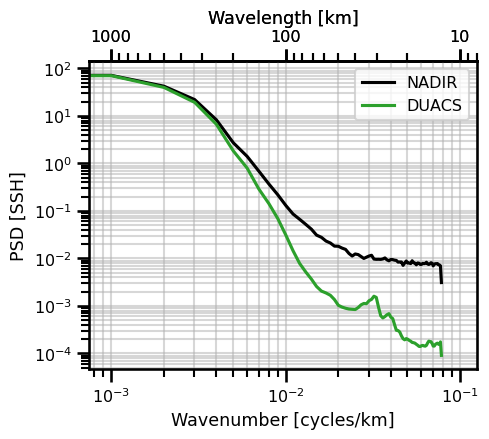

In [62]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_both(
    ds_psd,
    freq_scale=1, 
    units="km",
    label="NADIR",
    color="black",
)
psd_iso_plot.plot_both(
    ds_psd_interp,
    freq_scale=1, 
    units="km",
    label="DUACS",
    color="tab:green",
)

# set custom bounds
psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD [SSH]")

plt.show()

### Power Spectrum Score

$$
\text{PSD}(u,\hat{u}) = 1 - \frac{\mathcal{F}(u) - \mathcal{F}(\hat{u})}{\mathcal{F}(u)}
$$

where $\mathcal{F}$ is the power spectrum transformation.

In [63]:
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

#### Resolved Scale

We can assign an arbitrary threshhold which we decide as the "resolved scale" for the quantity of interest. In this case, we decided 0.5 which is the minimum signal-to-noise ratio that we deem trustworthy.

In [64]:
find_intercept_1D(
            x=ds_psd_score.values, 
    y=1./(ds_psd_score.wavenumber), 
    level=0.5,
    kind="slinear",
    fill_value="extrapolate"
)        

array(152.67922533)

#### Figure

In [65]:
class PlotPSDScoreIsotropic(PlotPSDIsotropic):
    
    def _add_score(
        self,
        da,
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name=""
):
        
        dim = da.dims[0]
        self.ax.set(ylabel="PSD Score", yscale="linear")
        self.ax.set_ylim((0,1.0))
        self.ax.set_xlim((
            10**(-3) - 0.00025,
            10**(-1) +0.025,
        ))
        
        resolved_scale = freq_scale / find_intercept_1D(
            x=da.values, y=1./(da[dim].values+1e-15), level=threshhold
        )        
        self.ax.vlines(
            x=resolved_scale, 
            ymin=0, ymax=threshhold, 
            color=threshhold_color,
            linewidth=2, linestyle="--",
        )
        self.ax.hlines(
            y=threshhold,
            xmin=np.ma.min(np.ma.masked_invalid(da[dim].values * freq_scale)),
            xmax=resolved_scale, color=threshhold_color,
            linewidth=2, linestyle="--"
        )        
        label = f"{name}: {1/resolved_scale:.0f} {units} "
        self.ax.scatter(
            resolved_scale, threshhold,
            color=threshhold_color, marker=".",
            linewidth=5, label=label,
            zorder=3
        )
        
        
    def plot_score(
        self, 
        da, 
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name="",
        **kwargs
    ):
        
        self.plot_both(da=da, freq_scale=freq_scale, units=units, **kwargs)
        self._add_score(
            da=da, 
            freq_scale=freq_scale,
            units=units,
            threshhold=threshhold, 
            threshhold_color=threshhold_color,
            name=name
        )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


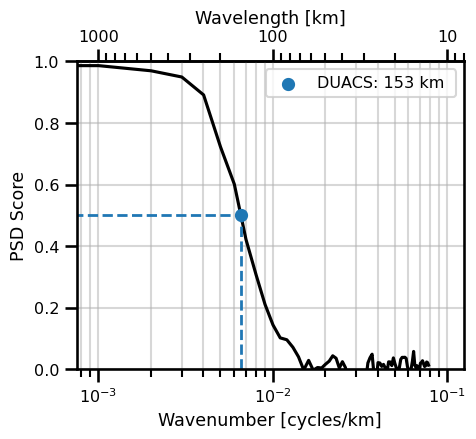

In [66]:
psd_iso_plot = PlotPSDScoreIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_score(
    ds_psd_score,
    freq_scale=1, 
    units="km",
    name="DUACS",
    color="black",
    threshhold=0.5,
    threshhold_color="tab:blue"
    
)
plt.legend()
plt.show()